# < Various Techniques >

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, utils
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np

## 1. Augmentations
https://pytorch.org/vision/main/transforms.html

In [2]:
transform_STL10 = transforms.Compose([
    transforms.RandomResizedCrop(size=96, scale=(0.2, 1.)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),
    transforms.RandomRotation(10),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    # transforms.Normalize(mean=(0.4467, 0.4398, 0.4066), std=(0.2241, 0.2215, 0.2239))
])

train_loader_raw = datasets.STL10(
        root      = './dataset/STL10', 
        split     = 'train',
        download  = True,
        transform=transforms.ToTensor())

train_loader_aug = datasets.STL10(
        root      = './dataset/STL10', 
        split     = 'train',
        download  = True,
        transform = transform_STL10)

Files already downloaded and verified
Files already downloaded and verified


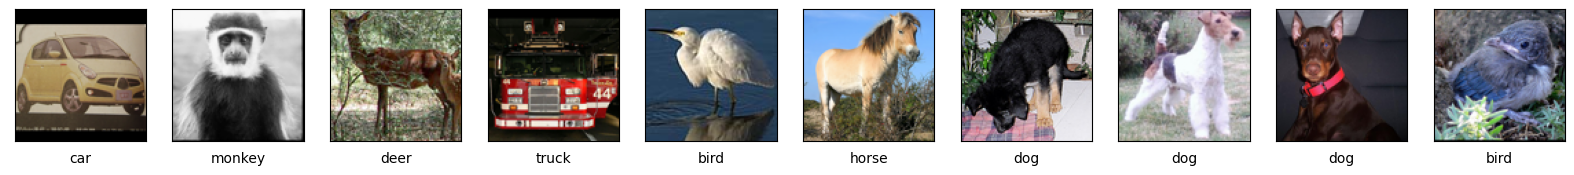

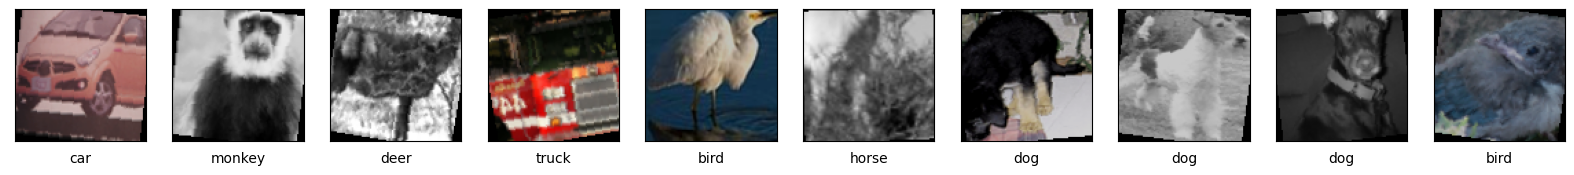

In [3]:
class_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

np.random.seed(15)
torch.manual_seed(0)

grid_size=10
rnd_ind = np.random.randint(0, len(train_loader_raw), grid_size)


x_grid = np.array([train_loader_raw[i][0].cpu().numpy() for i in rnd_ind])
y_grid = np.array([train_loader_raw[i][1] for i in rnd_ind])

plt.figure(figsize=(20,200))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_grid[i].transpose([1, 2, 0]))
    plt.xlabel(class_names[y_grid[i]])
plt.show()

x_grid = np.array([train_loader_aug[i][0].cpu().numpy() for i in rnd_ind])
y_grid = np.array([train_loader_aug[i][1] for i in rnd_ind])

plt.figure(figsize=(20,200))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_grid[i].transpose([1, 2, 0]))
    plt.xlabel(class_names[y_grid[i]])
plt.show()



### - AutoAug / RandAug / CTAug ...


## 2. Label Smoothing

### - Cross_entropy with a parameter

In [ ]:
loss = F.cross_entropy(output, target, label_smoothing=0.1)

# Szegedy, Christian, et al. "Rethinking the inception architecture for computer vision." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.


### - Modify the labels

In [5]:
def smooth_one_hot(true_labels: torch.Tensor, classes: int, smoothing=0.0):
    """
    if smoothing == 0, it's one-hot method
    if 0 < smoothing < 1, it's smooth method

    """
    assert 0 <= smoothing < 1
    confidence = 1.0 - smoothing
    label_shape = torch.Size((true_labels.size(0), classes))

    with torch.no_grad():
        true_dist = torch.empty(size=label_shape, device=true_labels.device)
        true_dist.fill_(smoothing / (classes - 1))
        true_dist.scatter_(1, true_labels.data.unsqueeze(1), confidence)
    return true_dist

true_labels = [0, 1, 2]
smoothing = 0.1
no_class = 4

smooth_label = smooth_one_hot(torch.Tensor(true_labels).type(torch.int64), no_class, smoothing)
print(smooth_label)

smooth_label = np.eye(no_class)[true_labels] * (1 - smoothing - (smoothing / (no_class - 1))) + (smoothing / (no_class - 1))
print(smooth_label)


tensor([[0.9000, 0.0333, 0.0333, 0.0333],
        [0.0333, 0.9000, 0.0333, 0.0333],
        [0.0333, 0.0333, 0.9000, 0.0333]])
[[0.9        0.03333333 0.03333333 0.03333333]
 [0.03333333 0.9        0.03333333 0.03333333]
 [0.03333333 0.03333333 0.9        0.03333333]]


## 3. MixUP

### - Examples of MixUP
Zhang, Hongyi, et al. "mixup: Beyond empirical risk minimization." arXiv preprint arXiv:1710.09412 (2017).

In [6]:
# https://github.com/facebookresearch/mixup-cifar10/blob/eaff31ab397a90fbc0a4aac71fb5311144b3608b/train.py#L119

def mixup_data(x1, x2, alpha=1.0):
    lam = np.random.beta(alpha, alpha, x1.shape[0]).reshape([x1.shape[0], 1, 1, 1])

    print(lam.shape)
    print(x1.shape)

    mixed_x = lam * x1 + (1 - lam) * x2
    return mixed_x, lam.squeeze()

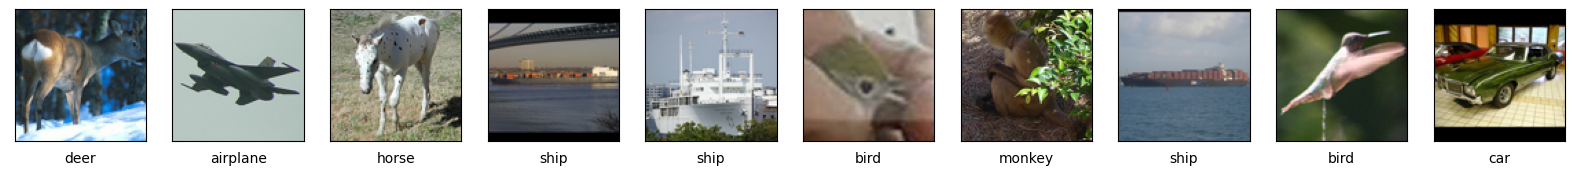

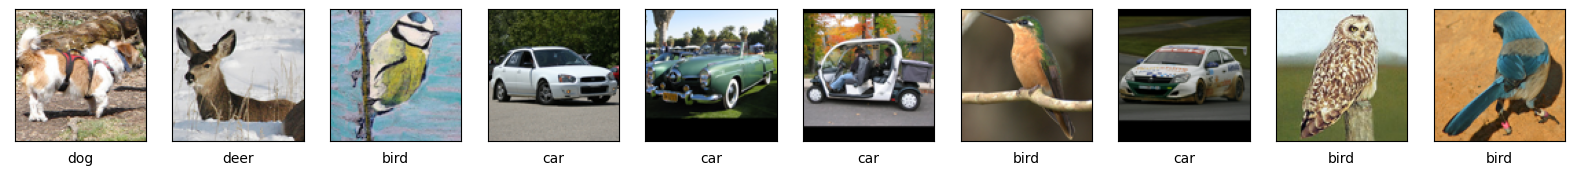

In [7]:
class_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

np.random.seed(99)
torch.manual_seed(99)

grid_size=10
rnd_ind = np.random.randint(0, len(train_loader_raw), grid_size)


x_grid1 = np.array([train_loader_raw[i][0].cpu().numpy() for i in rnd_ind])
y_grid1 = np.array([train_loader_raw[i][1] for i in rnd_ind])

plt.figure(figsize=(20,200))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_grid1[i].transpose([1, 2, 0]))
    plt.xlabel(class_names[y_grid1[i]])
plt.show()


rnd_ind = np.random.randint(0, len(train_loader_raw), grid_size)

x_grid2 = np.array([train_loader_raw[i][0].cpu().numpy() for i in rnd_ind])
y_grid2 = np.array([train_loader_raw[i][1] for i in rnd_ind])

plt.figure(figsize=(20,200))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_grid2[i].transpose([1, 2, 0]))
    plt.xlabel(class_names[y_grid2[i]])
plt.show()

(10, 1, 1, 1)
(10, 3, 96, 96)


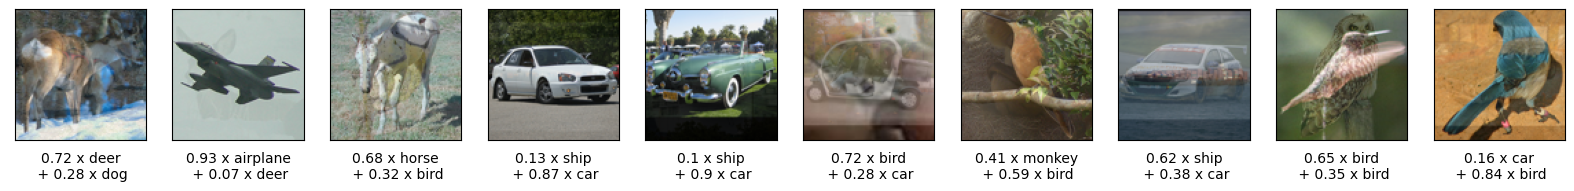

In [8]:
mixed_x, lam = mixup_data(x_grid1, x_grid2)

plt.figure(figsize=(20,200))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(mixed_x[i].transpose([1, 2, 0]))
    plt.xlabel(str(round(lam[i], 2)) + ' x ' + class_names[y_grid1[i]] + '\n + ' + str(round(1-lam[i], 2)) + ' x ' + class_names[y_grid2[i]])
plt.show()

### - MixUp in a batch

In [9]:
def mixup_data_in_a_batch(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha, x.shape[0]).reshape([x.shape[0], 1, 1, 1])

    batch_size = x.shape[0]

    index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam.squeeze()

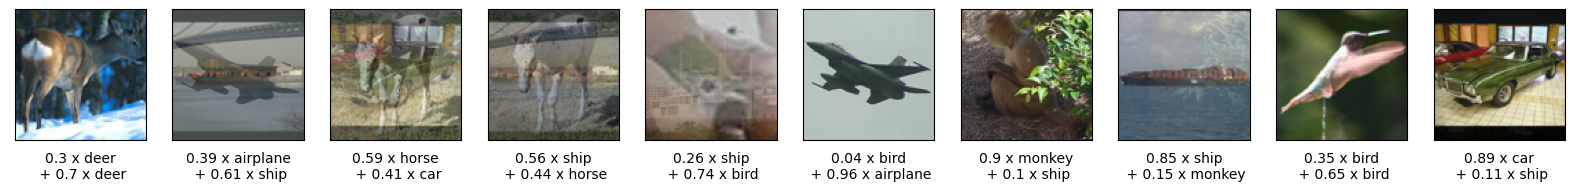

In [11]:

# print(x_grid1.shape)
mixed_x, y_a, y_b, lam = mixup_data_in_a_batch(x_grid1, y_grid1)

plt.figure(figsize=(20,200))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(mixed_x[i].transpose([1, 2, 0]))

    plt.xlabel(str(round(lam[i], 2)) + ' x ' + class_names[y_a[i]] + '\n + ' + str(round(1-lam[i], 2)) + ' x ' + class_names[y_b[i]])
plt.show()